## Loading the data

In [23]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

con = sqlite3.connect('resources/database.sqlite')

messages = pd.read_sql_query("""
SELECT Score, Summary
FROM Reviews
WHERE Score != 3
""", con)

i_data = pd.read_csv('resources/implement.csv')
reviews = i_data['Summary']

def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

Score = messages['Score']
Score = Score.map(partition)
Summary = messages['Summary']
X_train, X_test, y_train, y_test = train_test_split(Summary, Score, test_size=0.2, random_state=42)

## Cleaning the data
To format our data and build the Term-doc incidence matrix, many operations will be performed on the data :

- Stemming
- Lowering
- Tokenization
- Pruning (numbers and punctuation)

In [ ]:
stemmer = PorterStemmer()
from nltk.corpus import stopwords

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    #tokens = [word for word in tokens if word not in stopwords.words('english')]
    stems = stem_tokens(tokens, stemmer)
    return ' '.join(stems)

intab = string.punctuation
outtab = "                                "
trantab = str.maketrans(intab, outtab)

#--- Training set

corpus = []
for text in X_train:
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    corpus.append(text)
        
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(corpus)        
        
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#--- Test set

test_set = []
for text in X_test:
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    test_set.append(text)

X_new_counts = count_vect.transform(test_set)
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

#--- Implementation Set 
imp_set = []
for text in reviews:
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    imp_set.append(text)

review_counts = count_vect.transform(imp_set)
review_tfidf = tfidf_transformer.transform(review_counts)

from pandas import *
df = DataFrame({'Before': X_train, 'After': corpus})
print(df.head(20))

prediction = dict()

## Model Training and Prediciton

** Multinomial Naive Bayes **

In [25]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = model.predict(X_test_tfidf)

** Bernoulli Naive Bayes **

In [26]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB().fit(X_train_tfidf, y_train)
prediction['Bernoulli'] = model.predict(X_test_tfidf)

** Logistic Regression **

In [ ]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

## Results

In order to compare our learning algorithms, let's build the ROC curve. The curve with the highest AUC value will show our "best" algorithm.

In first data cleaning, stop-words removal has been used, but the results were much worse. Reason for this result could be that when people want to speak about what is or is not good, they use many small words like "not" for instance, and these words will typically be tagged as stop-words, and will be removed. This is why in the end, it was decided to keep the stop-words. For those who would like to try it by themselves, I have let the stop-words removal as a comment in the cleaning part of the analysis.

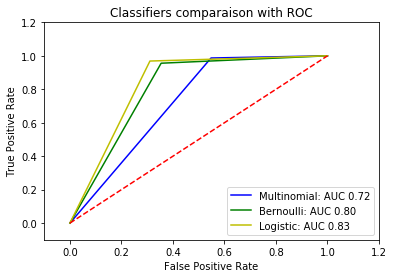

In [28]:
def formatt(x):
    if x == 'negative':
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

After plotting the ROC curve, it would appear that the Logistic regression method provides us with the best results, although the AUC value for this method is not outstanding...

Let's focus on logistic regression, and vizualise the accuracy, recall and confusion matrix of this model:

In [29]:
print(metrics.classification_report(y_test, prediction['Logistic'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.80      0.69      0.74     16379
   negative       0.94      0.97      0.96     88784

avg / total       0.92      0.93      0.92    105163



## Printing the confusion Matrix

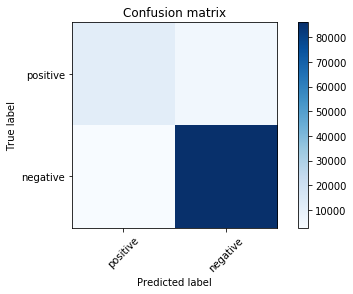

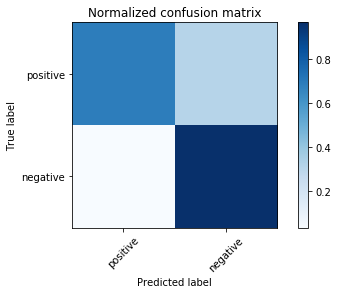

In [30]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(Score)))
    plt.xticks(tick_marks, set(Score), rotation=45)
    plt.yticks(tick_marks, set(Score))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm = confusion_matrix(y_test, prediction['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)    

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

## Predicting on Random input

In [31]:
out = logreg.predict(review_tfidf)
print(out)

['negative' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'negative' 'negative' 'positive' 'positive' 'positive'
 'positive' 'positive' 'negative' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'negative'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'negative' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'negative' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'posit